# Homotopic optimal control of interplanetary spacecraft

## Dynamics

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state variables
x, y, z, vx, vy, vz = symbols('x y z v_x v_y v_z', real=True)
m = symbols('m', real=True, nonnegative=True)

# position
p = Matrix([x, y, z])

# velocity
v = Matrix([vx, vy, vz])

# state
s = Matrix([p, v, [m]])
s.T

In [ ]:
# control parameters
um = symbols('u', real=True, positive=True)
ux, uy, uz =symbols('\\hat{u}_x \\hat{u}_y \\hat{u}_z', real=True)
uh = Matrix([ux, uy, uz])
u = Matrix([[um], uh])

# constants
c1, c2, mu = symbols('c_1 c_2 \\mu', real=True, positive=True)
T, isp, mu, g = symbols('T I_{sp} \\mu g_0', real=True, positive=True)
c1 = T
c2 = T/(isp*g)

# equations of motion
ds = Matrix([
    v,
    (-mu/((x**2 + y**2 + z**2)**(Rational(3/2))))*(p) + (c1*um/m)*uh,
    [-c2*um]
])
simplify(ds)

In [ ]:
# homotopy parameter
alpha, beta = symbols('\\alpha \\beta', real=True, nonnegative=True)

# Lagrangian
L = alpha + (1-alpha)*um
L = beta*L + (1-beta)*um**2
L.simplify()
print(L)

In [ ]:
 # costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True)
l.T

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# minimise Hamiltonian w.r.t. controls
lv = Matrix(l[3:6])
uhs = -lv/sqrt(sum([var**2 for var in lv]))
simplify(uhs)

In [ ]:
# new Hamiltonian
H1 = H.subs(ux, uhs[0]).subs(uy, uhs[1]).subs(uz, uhs[2])
ums = solve(H1.diff(um), um)[0]
ums

In [ ]:
lv = symbols('\lambda_v')

In [ ]:
ums.subs(beta, 1).simplify()

$$
\frac{1}{2(1-\beta)}
\left(
\frac{T \left(\pmb{\lambda}_v \cdot \pmb{\lambda}_v\right)}{ \lambda_v  m }
+
\frac{T \lambda_{m} }{ I_{sp}  g_{0} } +
\beta  \left(\alpha - 1\right)
\right)
$$

In [ ]:
ums.subs(beta, 1).subs(alpha, 0).simplify()

In [ ]:
ums.simplify().collect(isp*T*g).collect(beta*isp*g*m).collect(sqrt(sum(var**2 for var in l[3:6]))).simplify()

$$
\frac{
    -I_{sp} T g_0 \left( \pmb{\lambda}_v \cdot \pmb{\lambda}_v \right)
    + \lambda_v I_{sp} g_0 m \beta (1- \alpha)
    - \lambda_v \lambda_m T m
}{
    2 \lambda_v I_{sp} g_0 m (\beta -1)
}
$$

$$
\frac{1}{2(\beta - 1)}
\left(
\beta (1- \alpha)
-
\frac{
    T \left( \pmb{\lambda}_v \cdot \pmb{\lambda}_v \right)
}{
    \lambda_v  m 
} 
-
\frac{
      \lambda_m T 
}{
      I_{sp} g_0 
}
\right)
$$

$$
\frac{
    -I_{sp} T g_0 \left( \pmb{\lambda}_v \cdot \pmb{\lambda}_v \right)
    + \lambda_v I_{sp} g_0 m \left( 1 - \alpha \right)
    - T \lambda_m m \lambda_v
}{
    m \lambda_v
}
$$

In [ ]:
us = Matrix([[ums], uhs])

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
Matrix([
    ums.subs(alpha, 0).subs(beta, 0),
    ums.subs(alpha, 0).subs(beta, 1),
    ums.subs(alpha, 1).subs(beta, 0),
    ums.subs(alpha, 1).subs(beta, 1),
    ums.subs(alpha, 0),
    ums.subs(alpha, 1),
    ums.subs(beta, 0),
    ums.subs(beta, 1),
    ums
])

In [ ]:
tangent = Matrix([
    (-mu/(p.norm()**3))*p,
    v
])
tangent = tangent/tangent.norm()
l[:-1, :].dot(tangent).simplify().collect()

In [ ]:
# regular optimal control
ums.subs(beta, 1).simplify().subs(sqrt(sum([var**2 for var in l[3:6]])), '\lambda_v')

$$
\frac{\pmb{\lambda}_v \cdot \pmb{\lambda}_v}{\lambda_v m} + \lambda_m + 1 + \alpha
$$

In [ ]:
# effort optimal control
ums.subs(beta, 1).subs(alpha, 0).simplify().subs(sqrt(sum([var**2 for var in l[3:6]])), '\lambda_v')

$$
\frac{\pmb{\lambda}_v \cdot \pmb{\lambda}_v}{\lambda_v m}
+
\lambda_m
+
1
$$

In [ ]:
# time optimal control
ums.subs(beta, 1).subs(alpha, 1).simplify().subs(sqrt(sum([var**2 for var in l[3:6]])), '\lambda_v')

In [ ]:
# effort or time optimal control

$$
\frac{\pmb{\lambda}_v \cdot \pmb{\lambda}_v}{\lambda_v m}
+
\lambda_m
$$

$$
\frac{\mu}{r^3} \pmb{\lambda}_v - \frac{3\mu}{r^5}\left( \pmb{\lambda}_v \cdot \pmb{r} \right)
$$

tangent

## Base trajectory

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt, pygmo as pg, pykep as pk
sys.path.append('../src/')
from spacecraft import Spacecraft
from indirect import Indirect
%matplotlib

Using matplotlib backend: TkAgg


In [2]:
# instantiate problem
seg = Spacecraft(T=0.2, isp=2500, m=1000)

In [3]:
# initial state
s0 = np.hstack((*pk.planet.jpl_lp('earth').eph(pk.epoch(0)), seg.M))

# homotopy parameters
alpha = 0
seg.beta = 0

# duration bounds in days
Tlb = 100
Tub = 500

# costates bounds
lb = 50

# decision vector guess
zg = [379.20912013,   0.93398202,  12.76567896, -45.55493263,  -8.26940351, 49.99989562, 3.00127225, -8.58992837, 8.32972382]

In [4]:
# solve single trajectory
z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)

# solve multiple candidate trajectories in parallel
#zl, fl, feasl = seg.solve_par(s0, alpha, 200, 450, 50, npar=1000)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


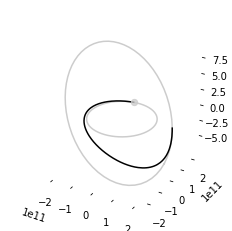

In [5]:
# plot trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
ax = seg.plot_traj(sl, alpha=1)
plt.show()

In [ ]:
sl[-1, :seg.sdim]

# Policy homotopy in $\beta \times [0, 1] : \alpha = 0$

In [ ]:
# homotopy
alpha = 0
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta0 = np.load('spacecraft_z_beta_homotopy_alpha_0.npy'); alpha = 0

In [ ]:
# plot homotopy
fig = plt.figure()
for i, t in enumerate(Ta0):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta0) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 1$

In [ ]:
# homotopy
alpha = 1
beta = 0
betag = 0.999
#T = seg.homotopy_beta(s0, alpha, beta, Tlb, Tub, lb, z, betag, step=0.1, verbose=True)
Ta1 = np.load('spacecraft_z_beta_homotopy_alpha_1.npy'); alpha = 1

In [ ]:
# plot homotopy
for i, t in enumerate(Ta1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    seg.beta = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Ta1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
ax1 = ax
plt.show()

# Policy homotopy in $\alpha \times [0, 1] : \beta = 1$

In [ ]:
# homotopy
alpha = 0
alphag = 1
seg.beta = 0.999
#z = Ta0[-1][0]
#Tb1 = seg.homotopy(s0, alpha, Tlb, Tub, lb, z, alphag, step=0.1, verbose=False)
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')

In [ ]:
%matplotlib
# plot homotopy
for i, t in enumerate(Tb1):
    z = t[0]
    tf = z[0]
    l0 = z[2:]
    alpha = t[1]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
    elif i == len(Tb1) - 1:
        seg.plot_traj(sl, alpha=1, mark="k--", ax=ax)
    else:
        seg.plot_traj(sl, ax=ax)
ax2 = ax
plt.show()

## Comparing policy homotopies

In [ ]:
# figure
fig, ax = plt.subplots(3, sharex=True)

alpha = 0
for i, sol in enumerate(Ta0):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta0) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta0) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
    
alpha = 1
for i, sol in enumerate(Ta1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    if i == len(Ta1) - 1:
        seg.beta = 0.99999999999
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    else:
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(Ta1) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
        
seg.beta = 0.999999999
for i, sol in enumerate(Tb1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    alpha = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[2].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    elif i == len(Tb1) - 1:
        ax[2].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[2].plot(tl, ul[:,0], "k-", alpha=0.1)
    

ax[2].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$u$')
ax[1].set_ylabel(r'$u$')
ax[2].set_ylabel(r'$u$')
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].legend(loc='lower left')
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.05)
ax[2].set_ylim(-0.05, 1.05)

fig.tight_layout()
#fig.savefig('spacecraft_u_full_homotopy.pdf', bbox_inches='tight')
plt.show()

## Random walks at $\beta = 0$

In [ ]:
# decision vector and homotopy parameter
z, seg.beta = Ta0[0]
alpha = 0

# number of serial perturbations per walk
n = 5

# number of walks
nw = 8

In [ ]:
# random walks in parallel
T = seg.random_walk_par(s0, z, alpha, n, Tlb, Tub, lb, nw, dsm=0.005, verbose=True)

In [ ]:
%matplotlib
# plot random walks
for i, t in enumerate(T):
    s0 = t[0]
    z = t[1]
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=1, mark="k-")
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.5)
plt.show()

## Database homotopy $\beta \times [0, 1], \alpha = 0$

In [6]:
#res = seg.homotopy_db_beta(T, alpha, beta, Tlb, Tub, lb, betag, step=0.1)
res = np.load('../src/spacecraft_beta_homotopy.npy')

In [ ]:
#np.save('spacecraft_db_beta_homotopy_a0.npy', res)

In [ ]:
%matplotlib
# plot database homotopy
alpha = 0
for i, r in enumerate(res):
    s0, z, seg.beta = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.1)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.1)
plt.show()

In [ ]:
s0zl = res[np.argwhere(res[:,2] >= 0.999).flatten(), :2]
s0zl

## Database homotopy $\alpha \times [0, 1], \beta = 1$

In [7]:
### get effort optimal trajectories
#s0zl = res[np.argwhere(res[:,2] >= 0.999).flatten(), :2]
alpha = 0
alphag = 1
seg.beta = 0.999
#T = seg.homotopy_db(s0zl, alpha, Tlb, Tub, lb, alphag, step=0.01)
T = np.load('../src/spacecraft_db_alpha_homotopy_beta_1.npy')
#T = np.load("spacecraft_db_alpha_homotopy_beta_1.npy")

In [ ]:
T.shape

In [ ]:
#np.save('spacecraft_db_alpha_homotopy_beta_1.npy', T)

In [8]:
%matplotlib
seg.beta = 0.999
# plot database homotopy
fig1, ax1 = plt.subplots(1)
for i, r in enumerate(T):
    s0, z, alpha = r
    tf = z[0]
    l0 = z[2:]
    tl, sl, ul = seg.propagate(tf, s0, l0, alpha, u=True)
    ax1.plot(tl, ul[:,0], "k-", alpha=0.01)
    if i == 0:
        fig, ax = seg.plot_traj(sl, alpha=0.01)
        ax.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax, alpha=0.01)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#fig.tight_layout()
fig.savefig('spacecraft_s_alpha_homotopy_db.pdf')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Using matplotlib backend: TkAgg


## Training a neural network

In [ ]:
from ann import *
import cloudpickle as cp
from matplotlib.ticker import FormatStrFormatter

In [ ]:
# assemble database
db = seg.gen_db(T, cat=True)
#db = np.load('spacecraft_db.npy')
#db = db[np.hstack((np.argwhere(db[:,8] == 1).flatten(), np.argwhere(db[:,8] == 0).flatten())), :]

In [ ]:
db.shape

In [ ]:
np.random.shuffle(db)

In [ ]:
pk.ic2par(s0[0:3], s0[3:6], pk.MU_SUN)

In [ ]:
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy'); seg.beta = 0.999
db = list()
for r in Tb1:
    z, alpha = r
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True, atol=1e-13, rtol=1e-13)
    sl[:,0:3] /= seg.L
    sl[:,3:6] /= seg.V
    sl[:,6] /= seg.M
    d = np.hstack((
        sl[:, :seg.sdim],
        np.full((len(sl), 1), alpha),
        ul.reshape(-1, seg.udim)
    ))
    db.append(d)
db = np.vstack(db)
db = db[np.hstack((np.argwhere(db[:,8] == 1).flatten(), np.argwhere(db[:,8] == 0).flatten())), :]

In [ ]:
#np.save('spacecraft_db.npy', db)
np.save("../src/data/sdata.npy", db[:20000, :])

In [ ]:
from multiprocessing import cpu_count, Pool

# train thrust throttle
tnet = Spacecraft_Thrust_Controller([8, 50, 50, 50, 1])
tnet.db = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [8])

# train direction
dnet = Spacecraft_Direction_Controller([8, 50, 50, 50, 2])
dnet.db = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [9, 10, 11])

# parallel function
def net_train(net):
    net.train(net.db.i[:5000], net.db.o[:5000], epo=500, lr=1e-3, ptst=0.1, gpu=False)
    return net

# train in parallel
nets = [tnet, dnet]
tnet, dnet = Pool(cpu_count()).map(net_train, nets)

mlp = Spacecraft_Controller_Joined(tnet, dnet)

In [ ]:
# get data ready for training 
data = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11])
#db = Data(db, [0, 1, 2, 3, 4, 5, 6, 7], [8])

In [ ]:
data.i.chunk(5)

In [ ]:
# instantiate the neural network
mlp = Spacecraft_Controller([seg.sdim + 1, 100, 100, 100, 3])
#mlp = Spacecraft_Throttle_Controller([seg.sdim + 1, 50, 50, 50, 1])

In [ ]:
#mlp.train(data.i, data.o, epo=1000, lr=1e-4, ptst=0.01, gpu=False)
mlp.train(data.i[:20000], data.o[:20000], epo=2000, lr=1e-4, ptst=0.1, gpu=True)

In [ ]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
#ax.set_yscale('log')
ax.set_xscale('log')

plt.show()

In [ ]:
snets = cp.load(open("../src/spacecraft_nets.p", "rb"))
fig, ax = plt.subplots(1, sharex=True, sharey=False)

# line colours
colors = np.linspace(0.8, 0, 4)

# pendulum nets
for i, net in enumerate(snets):
    ax.plot(net.ltrn, color=str(colors[i]), linestyle="-", label=r'${} \times {}$'.format(net.shape[1], net.nl-2))
    ax.plot(net.ltst, color=str(colors[i]), linestyle="--")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$MSE$')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.tight_layout()
ax.legend(loc='best')
plt.show()

In [ ]:
[min(net.ltst) for net in snets]

In [ ]:
mlp = snets[np.argmin([net.ltrn[-1] for net in snets])]
mlp

In [ ]:
mlp.cpu()

## Neural network accuracy

In [ ]:
Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy'); seg.beta = 0.9999999999

In [ ]:
#mlp.throttle
#seg = Spacecraft(T=0.2, isp=2500, m=1000)
# alpha homotopy
#Tb1 = np.load('spacecraft_z_alpha_homotopy_beta_1.npy'); seg.beta = 0.999

# effort optimal base
z = Tb1[0][0]
alpha = 0
tl0, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
sl[:,0:3] /= seg.L
sl[:,3:6] /= seg.V
sl[:,6] /= seg.M
a0i = np.hstack((sl[:,:seg.sdim], np.full((len(sl), 1), alpha)))
a0o = ul
a0op = mlp(torch.from_numpy(a0i)).detach().numpy()

# time optimal base
z = Tb1[-1][0]
alpha = 1
tl1, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
sl[:,0:3] /= seg.L
sl[:,3:6] /= seg.V
sl[:,6] /= seg.M
a1i = np.hstack((sl[:,:seg.sdim], np.full((len(sl), 1), alpha)))
a1o = ul
a1op = mlp(torch.from_numpy(a1i)).detach().numpy()

In [ ]:
# plot
fig, ax = plt.subplots(4, 2, sharex=True, sharey=False)
for i in range(4):
    ax[i][0].plot(tl0, a0o[:, i], "k--")
    ax[i][1].plot(tl1, a1o[:, i], "k--")
    ax[i][0].plot(tl0, a0op[:, i], "k-", alpha=0.5)
    ax[i][1].plot(tl1, a1op[:, i], "k-", alpha=0.5)
    if i == 0:
        ax[i][0].set_ylim(-0.1, 1.1)
        ax[i][1].set_ylim(-0.1, 1.1)
    else:
        ax[i][0].set_ylim(-1.1, 1.1)
        ax[i][1].set_ylim(-1.1, 1.1)
ax[-1, 0].set_xlabel("Days")
ax[-1, 1].set_xlabel("Days")
ax[0, 0].set_ylabel(r"$u$")
ax[1, 0].set_ylabel(r"$\hat{u}_x$")
ax[2, 0].set_ylabel(r"$\hat{u}_y$")
ax[3, 0].set_ylabel(r"$\hat{u}_z$")
ax[0, 1].legend(['Ground Truth', "Prediction"], loc="lower right", fontsize="x-small")
ax[0, 0].set_title(r"$\alpha=0$")
ax[0, 1].set_title(r"$\alpha=1$")

fig.tight_layout()
fig.savefig("spacecraft_ann_prediction.pdf", bbox_inches="tight")
plt.show()

## Simulating the neural network controller

In [ ]:
%matplotlib
seg.sf = None
# figures
fig, ax = plt.subplots(4, sharex=True, sharey=False)

# alpha homotopy solutions
sols = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')

# set beta parameter
seg.beta = 0.999

# desired alpha parameters
na = 20
sa = np.linspace(0, 1, na)

# for each desired alpha parameter
for i, a in enumerate(sa):
    
    # get decision vector and homotopy parameter
    z, alpha = sols[np.argmin(abs(sols[:, 1] - a))]
    tf = z[0] + 20
    print(z)
    
    # compute trajectory with policy with x0 and tf
    tl, sl, ul = seg.propagate_controller(tf, s0, mlp.predict, alpha, atol=1e-10, rtol=1e-10)
    
    # plot controls
    for j in range(4):
        ax[j].plot(tl, ul[:,j], "k-", alpha=0.3)
        
    # plot trajectory
    if i == 0:
        fig1, ax1 = seg.plot_traj(sl, alpha=0.3)
        ax1.set_aspect('equal')
    else:
        seg.plot_traj(sl, ax=ax1, alpha=0.3)
    
ax[-1].set_xlabel("Days")
ax[0].set_ylabel(r"$u$")
ax[1].set_ylabel(r"$\hat{u}_x$")
ax[2].set_ylabel(r"$\hat{u}_y$")
ax[3].set_ylabel(r"$\hat{u}_z$")
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
ax1.set_zlabel(r'$z$')
fig.tight_layout()
fig1.tight_layout()
fig.savefig("spacecraft_ann_control.pdf", bbox_inches="tight")
fig1.savefig("spacecraft_ann_trajectory.pdf", bbox_inches="tight")
plt.show()

## Policy trajectory optimality

In [ ]:
from scipy.integrate import simps
# which solution to use
i = -1

# get solution
z, alpha = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')[i]
tf = z[0]

# set beta parameter
seg.beta = 0.999

# compute trajectory with policy with x0 and tf
tl, sl, ul = seg.propagate_controller(tf, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
jp = seg.lagrangian(ul[:,0], alpha, seg.beta)
jp = simps(jp, tl)

# plot trajectory
fig, ax = seg.plot_traj(sl, mark="k-", alpha=1)

# compute optimal trajectory to xf from policy trajectory
seg.sf = sl[-1, :seg.sdim]
z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb=100, z=z)
tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, atol=1e-12, rtol=1e-12, u=True)
jo = seg.lagrangian(ul[:,0], alpha, seg.beta)
jo = simps(jo, tl)

# plot trajectory
seg.plot_traj(sl, ax=ax, mark="k--", alpha=1)

In [ ]:
abs(jp - jo)/jo*100

In [ ]:
%matplotlib
from scipy.integrate import simps


# alpha homotopy solutions
sols = np.load('spacecraft_z_alpha_homotopy_beta_1.npy')

# set beta parameter
seg.beta = 0.999

# desired alpha parameters
na = 11
sa = np.linspace(0, 1, na)

# results
opt_array = np.zeros((na, len(snets)))

# for each neural network
for i, net in enumerate(snets):
    net.cpu()

    # for each desired alpha parameter
    for j, a in enumerate(sa):

        # get decision vector and homotopy parameter
        z, alpha = sols[np.argmin(abs(sols[:, 1] - a))]
        tf = z[0]

        # compute trajectory with policy with x0 and tf
        tl, sl, ul = seg.propagate_controller(tf, s0, net.predict, alpha, atol=1e-13, rtol=1e-13)
        
        # compute cost of policy trajectory
        jp = seg.lagrangian(ul[:,0], alpha, seg.beta)
        jp = simps(jp, tl)
        
        # compute optimal trajectory to xf
        seg.sf = sl[-1, :seg.sdim]
        z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb=100, z=z)
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, atol=1e-12, rtol=1e-12, u=True)
        
        # compute cost of optimal trajectory
        jo = seg.lagrangian(ul[:,0], alpha, seg.beta)
        jo = simps(jo, tl)
        
        # compute relative optimality
        e = abs(jp - jo)/jo
        
        # message
        print("The optimality of net {} at alpha = {:.4f} is {:6f}%".format(net.shape, alpha, e*100))
        
        # record
        opt_array[j, i] = e

In [ ]:
import pandas as pd

In [ ]:
cols = [r'${} \times {}$'.format(net.shape[1], net.nl) for net in snets]
rows = ['{:.1f}'.format(a) for a in sa]
df = pd.DataFrame(opt_array*100, columns=cols, index=rows)
print(df.to_latex(header="Architecture"))

In [ ]:
df.mean().T

In [ ]:
pisode 1484; Testing Loss 0.08300689537962919; Training Loss 0.08476268094085267
Episode 1350; Testing Loss 0.05976686691764736; Training Loss 0.061904816916847336
Episode 1485; Testing Loss 0.08299662480140191; Training Loss 0.08475273336913237
Episode 754; Testing Loss 0.0588751996960444; Training Loss 0.06099920870483687
Episode 1351; Testing Loss 0.05976431723441644; Training Loss 0.06190227695845
Episode 1486; Testing Loss 0.08298636260854146; Training Loss 0.08474279376129348